In [2]:
#!pip install tensorflow
#!pip install keras
#!pip install pydot
#!pip install graphviz

# Redes Recurrentes

En este Notebook vamos a parender a crear y entrenar redes recurrentes usando la librería **Keras**. En la primer sección vamos a resolver un problema de clasificación de imágenes y en la segunda sección un problema de regresión.

## 1) Introducción a redes recurrentes con Keras

Vamos a empezar por entrenar una red recurrente para predecri una serie temporal muy sencilla (períodica).

### 1.1) Generando el Dataset


Primero importamos las funciones de las librerias que vamos a utilizar:

In [3]:
# Imports de utilidades de Python
import numpy as np
import matplotlib.pyplot as plt

# Imports de Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN

2024-11-01 11:48:59.467247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Generemos ahora la serie temporal con la que vamos a entrenar nuestra Red Recurrente.

In [4]:
#Paso temporal
dt = 0.05

#Vector de tiempos
t = np.arange(0,40,dt)

# Generamos la señal temporal
raw_seq = np.sin(2*np.pi * 2 * t) + 0.5 * np.sin(2*np.pi * t)
# Maximo de la señal para normalizar
maximo = np.max(np.abs(raw_seq))
# Normalizamos
raw_seq = raw_seq/maximo

Veamos que forma tiene:

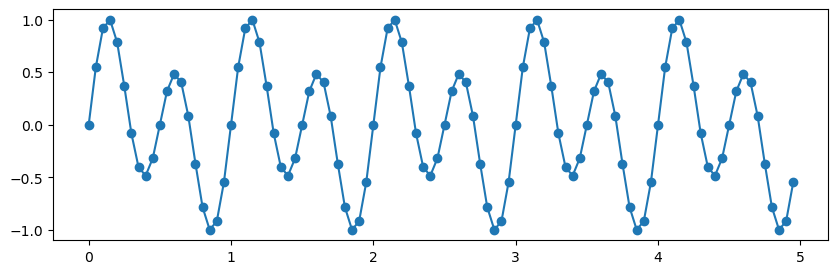

In [5]:
plt.figure(figsize=(10,3))
plt.plot(t[0:100], raw_seq[0:100],'-o')
plt.show()

Definimos la funcion `split_sequence` que toma como entrada la serie temporal y la cantidad de puntos que vamos a mirar para predecir el siguiente, llamada `look_back`. A partir de estos dos valores genera un dataset moviendo esta ventana de tamaño `look_back` a lo largo de la serie temporal.

In [6]:
def split_sequence(sequence, look_back):
    X, y = list(), list()
    # Recorremos la serie correspondiente al train y armamos el dataset
    for i in range(look_back, len(sequence)):
        X.append(sequence[i-look_back:i])
        y.append(sequence[i])
    X, y = np.array(X), np.array(y)
    return X, y

Definimos una ventana temporal de 5 valores y generamos nuestro dataset a partir de la señal temporal. Notemos que al ser una señal de un único valor (es una señal escalar), entonces la cantidad de features por cada paso temporal `n_features` es igual a 1. (en el caso general, podríamos aplicar la misma mecánica a series multivariadas).

In [7]:
# choose a number of time steps
look_back = 5

# Cantidad de valores por cada paso temporal
n_features = 1

# split into samples
X, y = split_sequence(raw_seq, look_back)

# Le damos la forma adecuada a los datos para entrar a la red recurrente
# reshape from [samples, timesteps] into [samples, look_back, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))

print(X.shape)
print(y.shape)

(795, 5, 1)
(795,)


Por último separamos la señal en train y test:

In [8]:
# Proporcion entre train y test
proporcion = 0.75

# Indice de separacion entre train y test
indice_test = int(proporcion * X.shape[0])

X_train = X[:indice_test]
y_train = y[:indice_test]
X_test = X[indice_test:]
y_test = y[indice_test:]

### 1.2) Entrenando el modelo

Para definir una red recurrente vamos a construir un modelo secuencial igual que lo hicimos en los Notebooks 3 y 4. Con la diferencia que esta vez debemos agregar a nuestro modelo una capa `SimpleRNN` o `LSTM`, dependiendo el tipo de red recurrente que querramos.

Luego de la capa recurrente, debemos agregar una capa densa, la cual leerá el último estado del **hidden space**. En este caso, al tener un problema de regresión en el cual la salida del modelo debe ser un único valor numérico, vamos a utilizar como capa de salida una única unidad con activación lineal.

Si quieren leer con mas detalle sobre Redes Recurrente y LSTMs, les recomiendo [este artículo](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) sobre el tema.

In [9]:
# Definimos el modelo Secuencial
model = Sequential()

# Agregamos la capa Recurrente (Puede ser LSTM o RNN)
model.add(SimpleRNN(10, activation='tanh', input_shape=(look_back, n_features)))
# model.add(LSTM(20, activation='tanh', input_shape=(look_back, n_features)))

# Agregamos la capa de salida (lee el hidden Space de la recurrente)
model.add(Dense(1,activation='linear'))

# Compilamos el modelo
model.compile(optimizer='adam', loss='mse')

2024-11-01 11:49:03.529939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Ya podemos entrenar nuestro modelo:

In [10]:
history = model.fit(X_train, y_train, epochs=200, verbose=0,validation_data=(X_test, y_test))

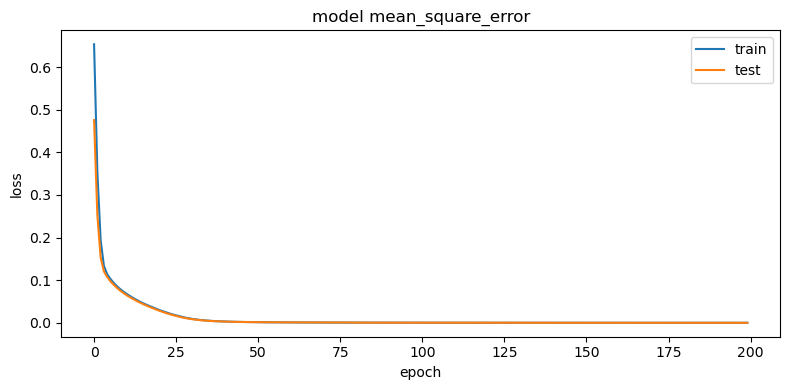

In [11]:
# plotting the metrics
fig = plt.figure(figsize = (8,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean_square_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
# plt.ylim(0.00,0.04)
plt.tight_layout()

### 1.3) Evaluando el resultado

Podemos mirar el error para algún valor particular del test set, pero esto no es muy informativo.

In [12]:
# Podemos inspeccionar para algun valor particular del test set
numero = 4
x_input = X_test[numero]
x_input = x_input.reshape((1, look_back, n_features))
yhat = model.predict(x_input, verbose=0)
print('Prediccion:', yhat[0][0])
print('Real:',y_test[numero])

Prediccion: 0.36499575
Real: 0.36884988549197395


Para evaluar mejor el modelo, podemos ver que sucede cuando intento predecir multiples pasos en el tiempo. Para realizar esto, debemos predecir el siguiente paso y luego usar ese mismo paso como entrada de la proxima predicción y así sucesivamente.

Con este fin vamos a definirnos la función `prediccion_pasos_adelante` cuya función es, a partir de una instancia dada, evolucionar el modelo N pasos hacia adelante.

In [13]:
def prediccion_pasos_adelante(model,vec_actual,pasos_adelante):

    # Preparamos una lista vacia que vamos a ir llenando con los valores predichos
    lista_valores = []
    # Recorremos n pasos hacia adelante
    for i in range(pasos_adelante):

        # Predecimos el paso siguiente
        # (El if determina si la estamos usando para la red recurrente o la densa)
        if len(vec_actual.shape)>1:
            # Prediccion Red Recurrente
            nuevo_valor = model.predict(vec_actual.reshape((1, vec_actual.shape[0], vec_actual.shape[1])))
        else:
            # Prediccion Red Densa
            nuevo_valor = model.predict(vec_actual.reshape(1, vec_actual.shape[0]))

        # Lo agregamos a la lista
        lista_valores.append(nuevo_valor[0][0])

        # Actualizmaos el vector actual con este paso
        vec_actual = np.roll(vec_actual, -1)
        vec_actual[-1] = nuevo_valor[0][0]

    lista_valores = np.asarray(lista_valores)

    return lista_valores

Calculemos con nuestro modelo entrenado una predicción de 100 pasos adelante y comparemosla con la señal real.

In [14]:
# Cantidad de pasos que queremos predecir hacia adelante
pasos_adelante = 100
indice_inicial = 0

# Tomamos un valor inicial del test set
vec_actual = X_test[indice_inicial]

# Calculamos la prediccion del modelo
predicciones_adelante = prediccion_pasos_adelante(model,vec_actual,pasos_adelante)

# Tomamos los valores esperados
valores_reales = y_test[indice_inicial:indice_inicial+pasos_adelante]

# Calculamos el error
diferencia = np.abs(predicciones_adelante-valores_reales)

1/1 [==============================] - 0s 23ms/step


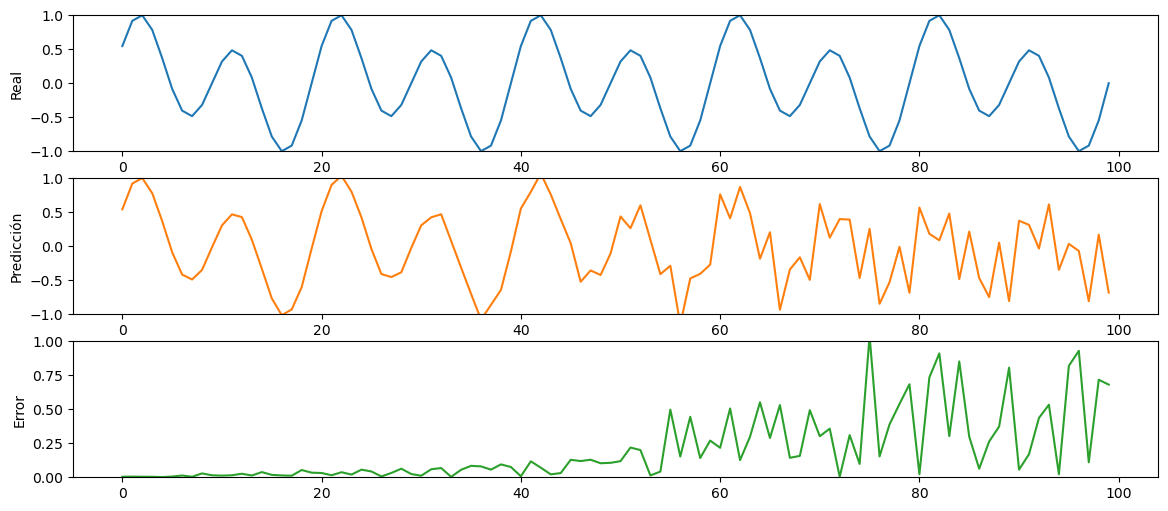

In [15]:
fig = plt.figure(figsize = (14,6))
plt.subplot(3,1,1)
plt.plot(valores_reales)
plt.ylabel('Real')
plt.ylim(-1,1)
plt.subplot(3,1,2)
plt.plot(predicciones_adelante,c='C1')
plt.ylabel('Predicción')
plt.ylim(-1,1)
plt.subplot(3,1,3)
plt.plot(diferencia,c='C2')
plt.ylabel('Error')
plt.ylim(0,1)
plt.show()

**Reflexionar:** ¿Les parece buena la predicción que está logrando el modelo de la señal? ¿Cómo la evaluarían de una manera mas sistemática?

## 2) Comparación con una Red Densa Clásica

En el notebook de la clase 4 usamos una red densa de regresión para predecir el siguiente valor en una serie temporal proviniente de un atractor caótico. Vamos a volver a realizar el mismo procedimiento, pero esta vez vamos a comparar el resultado de la predicción de esta red densa con una predicción hecha mediante una Red Recurrente.

**Observación:** Tenga en cuenta que, dada la naturaleza estocásticas de los algoritmos involucrados, el resultado de esta comparación puede variar ejecución a ejecución.

### 2.1) Generacion del Dataset
Vamos a generar la serie temporal caótica de la misma forma que en el Notebook 4.

In [16]:
def campo_vector_rossler(vec, t):

    # Definimos los parámetros del atractor
    a = 0.1
    b = 0.1
    c = 14

    # Como ahora las variables vienen en una lista (en el primer argumento: z)
    # primero las separamos para que sea más claro
    x = vec[0]
    y = vec[1]
    z = vec[2]

    # Y ahora calculamos las derivadas
    x_dot = 1*(-y - z)
    y_dot = 1*(x + a*y)
    z_dot = 1*(b + z*(x - c))

    return [x_dot, y_dot,z_dot]

def campo_vector_lorenz(vec, t):

    # Definimos los parámetros del atractor
    a = 10
    b = 28
    c = 8/3

    # Como ahora las variables vienen en una lista (en el primer argumento: z)
    # primero las separamos para que sea más claro
    x = vec[0]
    y = vec[1]
    z = vec[2]

    # Y ahora calculamos las derivadas
    x_dot = a*(y - x)
    y_dot = x *(b - z) - y
    z_dot = x*y - c*z

    return [x_dot, y_dot,z_dot]

In [17]:
from scipy.integrate import odeint

dt = 0.001
t = np.arange(0, 1000, dt)
num_steps = len(t)

# Y nos armamos una lista que contiene las condiciones iniciales
X0 = [10, 10, 0]

# Llamamos al odeint y vean que le pasamos la lista de condiciones iniciales
sol = odeint(campo_vector_lorenz, X0, t)
xs = sol[:,0]
ys = sol[:,1]
zs = sol[:,2]

Normalizamos y subsampleamos la a serie temporal. Quitamos el transitorio inicial y separamos la serie en un tramo de train y otro de test.

In [18]:
# Proporcion entre train y test
proporcion = 0.8

# Indice de separacion entre train y test
indice_test = int(proporcion * num_steps)

# Proporcion transitorio
transitorio = 0.1

# Indice fin del transitorio
indice_transitorio = int(transitorio * num_steps)

# Subsampleo temporal de la señal
subsampleo = 20

# Maximo de la señal para normalizar
maximo = np.max(np.abs(xs))

# Separamos la serie en 2 partes, una para el train set y otra para el test set.
training_set_scaled = np.divide(xs[indice_transitorio:indice_test:subsampleo],maximo)
test_set_scaled = np.divide(xs[indice_test::subsampleo],maximo)

Ahora, armaremos el dataset a utilizar a partir de esta serie temporal. Entrenaremos la red de manera de que la entrada sean N pasos consecutivos de la serie y su objetivo sea predecir el siguiente paso.

La cantidad de pasos para atras que verá la red esta determinada por la variable `look_back`.

In [19]:
# Definimos los pasos a mirar hacia atrás
look_back = 50

# Con la serie correspondiente al train armamos el dataset
X_train, Y_train = split_sequence(training_set_scaled, look_back)

# Con la serie correspondiente al test armamos el dataset
X_test, Y_test = split_sequence(test_set_scaled, look_back)

Veamos como son los valores que recibe la red en cada instancia:

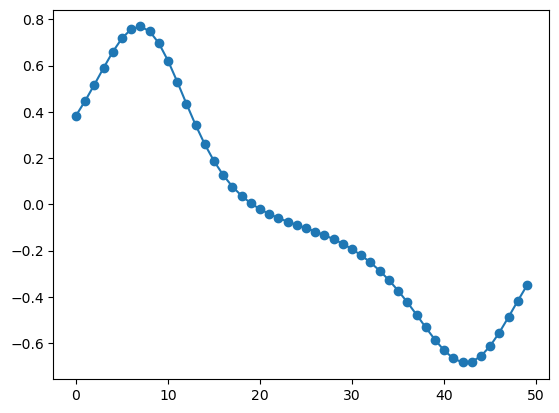

In [20]:
# Veamos como qued auna instancia
plt.plot(X_train[5],'-o')
plt.show()

Noten las dimensiones de las matrices obtenidas.

In [21]:
# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Train y shape", Y_train.shape)

print("Test matrix shape", X_test.shape)
print("Test y shape", Y_test.shape)

Train matrix shape (34950, 50)
Train y shape (34950,)
Test matrix shape (9950, 50)
Test y shape (9950,)


### 2.2) Entrenando la red densa

Vamos a definir una red neuronal densa para un problema de regresión de la misma forma que lo hicimos en el Notebook 4.

In [22]:
# building a linear stack of layers with the sequential model
model_dense = Sequential()
model_dense.add(Dense(8, activation='relu', input_shape=(look_back,)))
# model_dense.add(Dropout(0.2))

model_dense.add(Dense(8, activation='relu'))
# model_dense.add(Dropout(0.2))

model_dense.add(Dense(4, activation='relu'))
# model_dense.add(Dropout(0.2))

model_dense.add(Dense(1, activation='linear'))

In [23]:
# compiling the sequential model
model_dense.compile(loss='mse', metrics=['mean_absolute_error'], optimizer='adam')

Veamos cual es la cantidad de parámetros totales que posée este modelo. Para realizar una comparación justa, vamos a definir ambos modelos con un número de parámetros similares.

In [24]:
model_dense.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8)                 408       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


Ya podemos entrenar nuestrad red regresora.

In [25]:
# training the model and saving metrics in history
history_dense = model_dense.fit(X_train, Y_train,
          batch_size=32, epochs=30,
          verbose=2,
          validation_data=(X_test, Y_test))

Epoch 1/30
1093/1093 - 3s - loss: 0.0128 - mean_absolute_error: 0.0592 - val_loss: 6.7713e-04 - val_mean_absolute_error: 0.0182 - 3s/epoch - 3ms/step
Epoch 2/30
1093/1093 - 2s - loss: 3.5825e-04 - mean_absolute_error: 0.0135 - val_loss: 2.5028e-04 - val_mean_absolute_error: 0.0114 - 2s/epoch - 2ms/step
Epoch 3/30
1093/1093 - 2s - loss: 1.8916e-04 - mean_absolute_error: 0.0103 - val_loss: 1.7113e-04 - val_mean_absolute_error: 0.0102 - 2s/epoch - 2ms/step
Epoch 4/30
1093/1093 - 2s - loss: 1.3520e-04 - mean_absolute_error: 0.0087 - val_loss: 1.0991e-04 - val_mean_absolute_error: 0.0077 - 2s/epoch - 2ms/step
Epoch 5/30
1093/1093 - 2s - loss: 1.0590e-04 - mean_absolute_error: 0.0077 - val_loss: 1.3145e-04 - val_mean_absolute_error: 0.0092 - 2s/epoch - 2ms/step
Epoch 6/30
1093/1093 - 2s - loss: 8.6020e-05 - mean_absolute_error: 0.0070 - val_loss: 8.5852e-05 - val_mean_absolute_error: 0.0073 - 2s/epoch - 2ms/step
Epoch 7/30
1093/1093 - 2s - loss: 7.9727e-05 - mean_absolute_error: 0.0068 - val

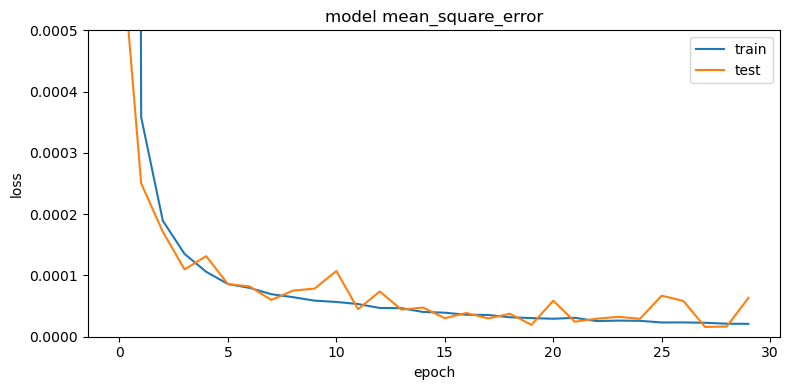

In [26]:
# plotting the metrics
fig = plt.figure(figsize = (8,4))
plt.plot(history_dense.history['loss'])
plt.plot(history_dense.history['val_loss'])
plt.title('model mean_square_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0,0.0005)
plt.tight_layout()

### 2.2) Entrenando la Red Recurrente

Entrenar la red recurrente será muy similar, pero debemos recordar acomodar el shape de los datos de la siguiente forma:

In [27]:
X_train_recurrente = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test_recurrente = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print("Train matrix shape", X_train_recurrente.shape)
print("Test matrix shape", X_test_recurrente.shape)

Train matrix shape (34950, 50, 1)
Test matrix shape (9950, 50, 1)


Ahora si, definamos nuestra red recurrente con una unica capa LSTM y una capa densa de salida.

In [28]:
# Definimos el modelo
model_recurrente = Sequential()

# Capa Recurrente (Puede ser LSTM o RNN)
model_recurrente.add(LSTM(10, activation='tanh', input_shape=(look_back, n_features))) # ,unroll=True))

# Como capa de salida (lee el hidden Space de la recurrente)
model_recurrente.add(Dense(1,activation='linear'))

# compiling the sequential model
model_recurrente.compile(loss='mse', metrics=['mean_absolute_error'], optimizer='adam')

Noten que la cantidad de parámetros es un poco menor pero del mismo orden que en la red densa.

In [29]:
model_recurrente.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


Ahora si, entrenemos la red.

In [30]:
# training the model and saving metrics in history
history_recurrente = model_recurrente.fit(X_train_recurrente, Y_train,
          batch_size=32, epochs=30,
          verbose=2,
          validation_data=(X_test_recurrente, Y_test))

Epoch 1/30
1093/1093 - 19s - loss: 0.0115 - mean_absolute_error: 0.0569 - val_loss: 1.4120e-04 - val_mean_absolute_error: 0.0088 - 19s/epoch - 17ms/step
Epoch 2/30
1093/1093 - 18s - loss: 6.5128e-05 - mean_absolute_error: 0.0058 - val_loss: 3.1921e-05 - val_mean_absolute_error: 0.0042 - 18s/epoch - 16ms/step
Epoch 3/30
1093/1093 - 19s - loss: 1.4800e-05 - mean_absolute_error: 0.0028 - val_loss: 1.4502e-05 - val_mean_absolute_error: 0.0028 - 19s/epoch - 17ms/step
Epoch 4/30
1093/1093 - 19s - loss: 7.3330e-06 - mean_absolute_error: 0.0020 - val_loss: 4.5838e-06 - val_mean_absolute_error: 0.0015 - 19s/epoch - 17ms/step
Epoch 5/30
1093/1093 - 18s - loss: 5.0668e-06 - mean_absolute_error: 0.0017 - val_loss: 4.1424e-06 - val_mean_absolute_error: 0.0015 - 18s/epoch - 17ms/step
Epoch 6/30
1093/1093 - 18s - loss: 3.9171e-06 - mean_absolute_error: 0.0015 - val_loss: 8.1751e-06 - val_mean_absolute_error: 0.0020 - 18s/epoch - 16ms/step
Epoch 7/30
1093/1093 - 19s - loss: 3.5321e-06 - mean_absolute_

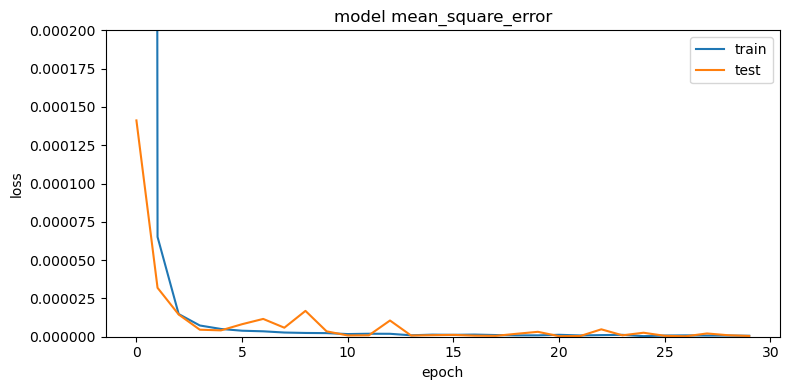

In [31]:
# plotting the metrics
fig = plt.figure(figsize = (8,4))
plt.plot(history_recurrente.history['loss'])
plt.plot(history_recurrente.history['val_loss'])
plt.title('model mean_square_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0,0.0002)
plt.tight_layout()

### 2.3) Analizamos los resultados

**Discutir:** En la tarea para la cual los entrenamos (predecir un paso adelante), ¿Qué modelo tiene un mejor desempeño? ¿Que valor debe observar para determinar esto?

Vamos ahora a utilizar ambos modelos para realizar predicciones de multiples pasos en el futuro y comparar los errores obtenidos por cada uno.


In [32]:
pasos_adelante = 100
inicio = 5

# Tomamos los valores esperados
valores_reales = Y_test[inicio:inicio+pasos_adelante]

# Tomamos el primer vector del X_test
principio = X_test[inicio]
predicciones_adelante_dense = prediccion_pasos_adelante(model_dense,principio,pasos_adelante)
diferencia_dense = np.abs(predicciones_adelante_dense-valores_reales)

# Tomamos el primer vector del X_test
principio_recurrente = X_test_recurrente[inicio]
predicciones_adelante_recurrente = prediccion_pasos_adelante(model_recurrente,principio_recurrente,pasos_adelante)
diferencia_recurrente = np.abs(predicciones_adelante_recurrente-valores_reales)

1/1 [==============================] - 0s 24ms/step


Geafiquemos el error de cada predicción en función del tiempo y comparemos.

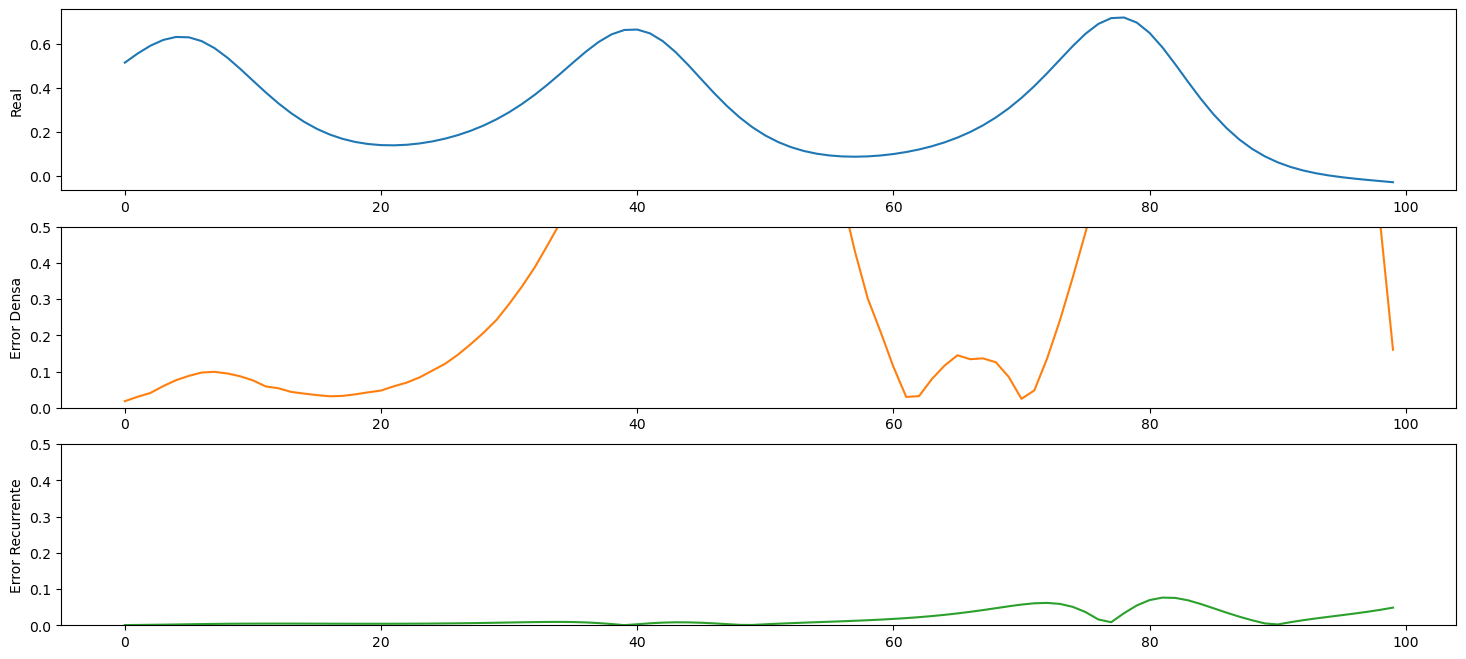

In [33]:
fig = plt.figure(figsize = (18,8))
plt.subplot(3,1,1)
plt.plot(valores_reales)
plt.ylabel('Real')
plt.subplot(3,1,2)
plt.plot(diferencia_dense,c='C1')
plt.ylabel('Error Densa')
plt.ylim(0,0.5)
plt.subplot(3,1,3)
plt.plot(diferencia_recurrente,c='C2')
plt.ylabel('Error Recurrente')
plt.ylim(0,0.5)
plt.show()

**Ejercicios:**

*   Si cambia la posición inicial (cambiando la variable `inicio`) verá que cambian los errores de predicción de los modelos.

*   ¿Les parece que esta es una serie temporal donde resulta facil hacer predicciones a largo plazo?

*   ¿Considera que el gráfico realizado es una manera adecuada de visualizar el error en función del numero de pasos? Diseñe una estrategia para cuantificar mejor el error de cada red en función del numero de pasos adelante (ver luego la sección **Extra** al final del notebook).

*   Pruebe modificar la arquitectura de ambas redes, tanto la densa como la recurrente, y vuelva a comparar los errores cometidos. Pruebe con redes de un menor número de parámetros (siempre intentando mantener los valores parejos entre ambas).



**Observación Importante:** La comparación realizada en esta sección es de caracter demostrativo. Para realizar una comparación rigurosa entre dos arquitecturas dadas, uno debería optimizar los hiperparámetros para cada una de estas (utilizando cross-validation) y generar varias relizaciones del proceso (ya que existe una gran componente estocástica en el mismo).

**Extra:** A continuación les propongo una posible estrategia para comparar la predicción a largo plazo de ambos modelos. Esto puede tardar unos minutos.

In [34]:
# Definimos cuantos pasas adelante vamos a evaluar y cuantas veces lo haremos
pasos_adelante = 50
iteraciones = 50

# Preparamos los vectores donde guardaremos los datos
errores_dense = np.zeros((iteraciones,pasos_adelante))
errores_recurrente = np.zeros((iteraciones,pasos_adelante))

# Defino un vector con los distintos indices de inicios que vamos a usar
# El factor 5 es para abarcar inicios distintos (mas separados)
vec_inicio = 5 * np.arange(0,iteraciones)

for i in range(len(vec_inicio)):

    print('Paso ',i,'de ',iteraciones)
    # Me voy parando en distintos lugares para comenzar la predicción
    inicio = vec_inicio[i]

    # Tomamos los valores esperados
    valores_reales = Y_test[inicio:inicio+pasos_adelante]

    # Tomamos el primer vector del X_test
    principio = X_test[inicio]
    predicciones_adelante_dense = prediccion_pasos_adelante(model_dense,principio,pasos_adelante)
    diferencia_dense = np.abs(predicciones_adelante_dense-valores_reales)

    # Tomamos el primer vector del X_test
    principio_recurrente = X_test_recurrente[inicio]
    predicciones_adelante_recurrente = prediccion_pasos_adelante(model_recurrente,principio_recurrente,pasos_adelante)
    diferencia_recurrente = np.abs(predicciones_adelante_recurrente-valores_reales)

    errores_dense[i,:] = diferencia_dense
    errores_recurrente[i,:] = diferencia_recurrente

Paso  0 de  50
1/1 [==============================] - 0s 28ms/step
Paso  1 de  50
1/1 [==============================] - 0s 26ms/step
Paso  2 de  50
1/1 [==============================] - 0s 24ms/step
Paso  3 de  50
1/1 [==============================] - 0s 26ms/step
Paso  4 de  50
1/1 [==============================] - 0s 26ms/step
Paso  5 de  50
1/1 [==============================] - 0s 27ms/step
Paso  6 de  50
1/1 [==============================] - 0s 31ms/step
Paso  7 de  50
1/1 [==============================] - 0s 24ms/step
Paso  8 de  50
1/1 [==============================] - 0s 24ms/step
Paso  9 de  50
1/1 [==============================] - 0s 25ms/step
Paso  10 de  50
1/1 [==============================] - 0s 28ms/step
Paso  11 de  50
1/1 [==============================] - 0s 32ms/step
Paso  12 de  50
1/1 [==============================] - 0s 25ms/step
Paso  13 de  50
1/1 [==============================] - 0s 24ms/step
Paso  14 de  50
1/1 [==============================] - 0s 

In [35]:
# Calculamos los estadísticos correspondientes

promedio_dense = np.mean(errores_dense, axis = 0)
std_dense = np.std(errores_dense, axis = 0)

promedio_recurrente = np.mean(errores_recurrente, axis = 0)
std_recurrente = np.std(errores_recurrente, axis = 0)

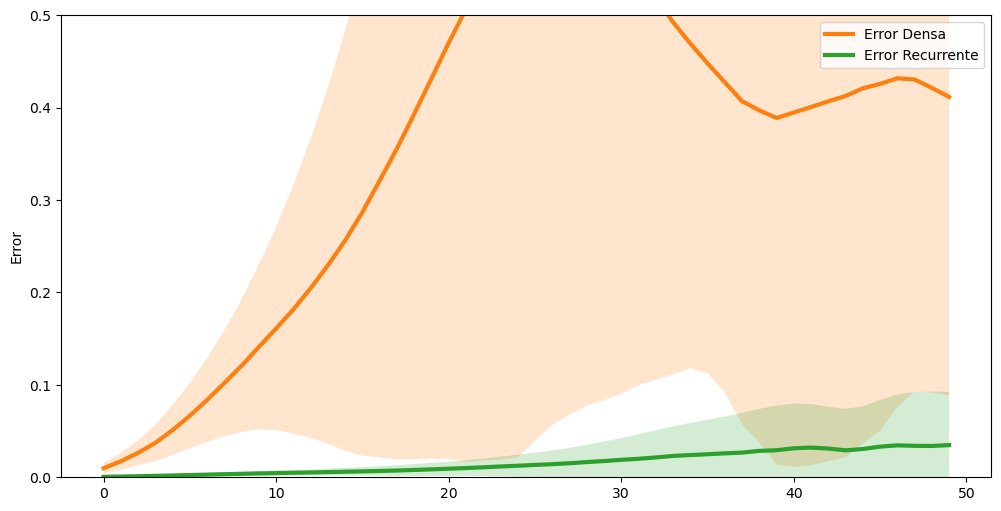

In [36]:
# Ploteamos el resultado

fig = plt.figure(figsize = (12,6))
t = np.arange(pasos_adelante)
plt.fill_between(t, promedio_dense+std_dense, promedio_dense-std_dense, facecolor='C1', alpha=0.2)
plt.fill_between(t, promedio_recurrente+std_recurrente, promedio_recurrente-std_recurrente, facecolor='C2', alpha=0.2)
plt.plot(t, promedio_dense,c='C1',label='Error Densa',linewidth=3)
plt.plot(t, promedio_recurrente,c='C2',label='Error Recurrente',linewidth=3)

plt.ylabel('Error')
plt.legend()
plt.ylim(0,0.5)
plt.show()